In [246]:
import importlib
import math
import os
import random
import numpy as np
import ssl
import urllib.request
import matplotlib.pyplot as plt
import certifi
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from tqdm import tqdm
from tqdm.auto import tqdm

import deviceUtility
import evaluator
import generateImages as generator
import plot_utility


In [ ]:
# Fix SSL certificate issue
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context)))

In [ ]:
gpu = deviceUtility.get_best_available_device()

### Hyperparameters

In [210]:
TIME_STEP = 1000
EPOCH_NUM = 54 
LEARNING_RATE = 1e-4

BETA_START = 1e-4
BETA_END = 0.02

BATCH_SIZE = 32

GUIDANCE_PROBABILITY = 0.5
GUIDANCE_WEIGHT = 1

SCHEDULER = "linear" #either 'linear' or 'cosine'

### Evaluation options

In [211]:
CALCULATE_FID = True
CALCULATE_IS = True

### Precalculations

In [212]:
def cosine_beta_scheduler(steps, s=0.008):
    """
    cosine scheduler as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = steps + 1
    x = torch.linspace(0, steps, steps, device=gpu)
    alphas_cumulative_prod = torch.cos(((x / steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumulative_prod = alphas_cumulative_prod / alphas_cumulative_prod[0]
    beta_values = 1 - (alphas_cumulative_prod[1:] / alphas_cumulative_prod[:-1])
    
    beta_min, beta_max = 0.0001, 0.9999
    return torch.clip(beta_values, beta_min, beta_max)

def get_betas(scheduler_name):
    """
    Returns a beta schedule based on the name of the scheduler, either 'linear' or 'cosine'
    """
    if scheduler_name == "linear":
        return torch.linspace(BETA_START, BETA_END, TIME_STEP, device=gpu)
    elif scheduler_name == "cosine":
        return cosine_beta_scheduler(TIME_STEP)
    else:
        raise NotImplementedError()
        

In [213]:
betas = get_betas(SCHEDULER) 
alphas = 1. - betas
alphas_cum_prod = torch.cumprod(alphas, 0)
alphas_cum_prod_prev = functional.pad(alphas_cum_prod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cum_prod = torch.sqrt(alphas_cum_prod)
sqrt_one_minus_alphas_cum_prod = torch.sqrt(1. - alphas_cum_prod)
posterior_variance = betas * (1. - alphas_cum_prod_prev) / (1. - alphas_cum_prod)

### Helper functions

In [241]:
def extract(equation, timestep, x_shape):
    """
    Extracts the values of the equation for the given timestep for every image in the batch.
    """
    size = timestep.shape[0]
    out = equation.gather(-1, timestep)
    return out.reshape(size, *((1,) * (len(x_shape) - 1)))


def forward_sample(image_batch, timestep, noise):
    """
    Forward pass of the diffusion model.
    Adds noise to an image at time t.
    If noise is not provided, it is sampled from a standard normal distribution.
    """

    # Extract the values for every image in the batch for the given timestep
    sqrt_alphas_cum_prod_t = extract(sqrt_alphas_cum_prod, timestep, image_batch.shape)
    sqrt_one_minus_alphas_cum_prod_t = extract(sqrt_one_minus_alphas_cum_prod, timestep, image_batch.shape)

    return sqrt_alphas_cum_prod_t * image_batch + sqrt_one_minus_alphas_cum_prod_t * noise


@torch.no_grad()
def reverse_sample(model, x, t, t_index, condition):
    """
    Reverse pass of the diffusion model.
    Given an image at time t, it predicts the image at time t-1.
    """
    condition = condition
    betas_t = extract(betas, t, x.shape)

    sqrt_one_minus_alphas_cum_prod_t = extract(
        sqrt_one_minus_alphas_cum_prod, t, x.shape
    )

    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean_unconditional = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cum_prod_t)

    model_mean_conditional = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t, condition) / sqrt_one_minus_alphas_cum_prod_t)
    model_mean_guided = (1 + GUIDANCE_WEIGHT) * model_mean_conditional - GUIDANCE_WEIGHT * model_mean_unconditional

    if t_index == 0:
        return model_mean_guided
    else:
        # Helps determine the amount of noise to remove from the image.
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean_guided + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def p_sample_loop(model,*, shape, conditionals, disable_tqdm = False, showPartial=None):
    b = shape[0]
    
    img = torch.randn(shape, device=gpu)  # Random noised image

    fig, axes = None, None
    if showPartial is not None:
        num_plots = TIME_STEP // showPartial + 1
        fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 4, 4))
        axes = axes.flatten() if num_plots > 1 else [axes]
        
    plot_index = 0
    
    for i in tqdm(reversed(range(0, TIME_STEP)), desc='Sampling loop time step.', total=TIME_STEP, disable=disable_tqdm):
        img = reverse_sample(model=model, x=img, t=torch.full((b,), i, device=gpu, dtype=torch.long), t_index=i,
                             condition=conditionals)
        
        if showPartial is not None and i % showPartial == 0:
            axes[plot_index].imshow(img[0].cpu().permute(1, 2, 0).squeeze().numpy(), cmap='gray')
            axes[plot_index].axis('off')
            plot_index += 1
            
    if showPartial is not None:
        plt.tight_layout()
        plt.show()
        
    return img


def p_losses(denoise_model, x_start, timestep, conditionals):

    noise = torch.randn_like(x_start)

    # Input image with the random noise and the timestep
    x_noisy = forward_sample(x_start, timestep, noise)

    # Feed the noisy image to the denoise model to predict the noise
    predicted_noise = denoise_model(x_noisy, timestep, conditionals)

    model_loss = functional.l1_loss(noise, predicted_noise)
    #model_loss = functional.mse_loss(noise, predicted_noise)
    return model_loss


### Sinusoidal Positional Embedding
As parameter of neural network are 
shared across time one should employ 
a sinusoidal embedding to encode the position of the input. 
Makes the neural network know which timestep it is at.

In [216]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(SinusoidalPositionalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        # Create a sinusoidal embedding for each position in time
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=gpu) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb

### Convolutional Layer
Classes which define the building blocks of the UNet architecture.
Consists of double convolutional layers with ReLU activation functions.
Also includes a time embedding layer which is added to the output of the first convolutional layer.

In [217]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super(Block, self).__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, out_channels),
            nn.ReLU(inplace=True)
        )

        self.condition_emb = nn.Sequential(
            nn.Linear(num_classes, out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, t, c=None):
        # First convolution
        h = self.relu(self.conv1(x))

        # Compute time embedding and reshape to match spatial dimensions
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(...,) + (None,) * 2]  # Shape (batch, channels, 1, 1)

        # Add time embedding.
        h = h + time_emb

        if isinstance(c, torch.Tensor):
            class_embedding = self.condition_emb(c)
            class_embedding = class_embedding[(...,) + (None,) * 2]  # Shape (batch, channels, 1, 1)
            h = h + class_embedding

        # Second convolution.
        h = self.relu(self.conv2(h))
        return h

### U-net
The UNet architecture for approximating the means of the posterior distribution.
The architecture consists of a contracting path, a bottleneck, and an expanding path.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.time_emb_dim = 32
        self.max_pool = nn.MaxPool2d(2, 2)

        # Contracting path.
        self.encoder1 = Block(1, 64, self.time_emb_dim)
        self.encoder2 = Block(64, 128, self.time_emb_dim)

        # Bottleneck: The crossing between contracting and expanding.
        self.bottleneck = Block(128, 256, self.time_emb_dim)

        # Expanding path.
        self.up_convolution_1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_convolution_2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.decoder1 = Block(256, 128, self.time_emb_dim)
        self.decoder2 = Block(128, 64, self.time_emb_dim)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t, c=None):
        # Contracting path.
        enc1_out = self.encoder1(x, t, c)
        pool_enc1_out = self.max_pool(enc1_out)

        enc2_out = self.encoder2(pool_enc1_out, t, c)
        pool_enc2_out = self.max_pool(enc2_out)

        # Bottleneck
        bottle_out = self.bottleneck(pool_enc2_out, t, c)

        # Expanding path.
        up_conv_1_out = self.up_convolution_1(bottle_out)
        crop_up_conv_1_out = crop_tensor(enc2_out, up_conv_1_out)
        dec1_out = self.decoder1(torch.cat([up_conv_1_out, crop_up_conv_1_out], dim=1), t, c)

        up_conv_2_out = self.up_convolution_2(dec1_out)
        crop_up_conv_2_out = crop_tensor(enc1_out, up_conv_2_out)
        dec2_out = self.decoder2(torch.cat([up_conv_2_out, crop_up_conv_2_out], dim=1), t, c)

        output = self.output_layer(dec2_out)

        return output

def crop_tensor(tensor, target_tensor):
    """
    Make the tensor the same size as the target tensor by cropping.
    """
    target_size = target_tensor.size()[2:]
    tensor_size = tensor.size()[2:]
    delta_h = (tensor_size[0] - target_size[0]) // 2
    delta_w = (tensor_size[1] - target_size[1]) // 2
    return tensor[:, :, delta_h:tensor_size[0] - delta_h,
           delta_w:tensor_size[1] - delta_w]

### Load data

In [ ]:
image_size = 28 # Length and width of the images
channels = 1  # Grey scale
num_classes = 10 # possible classes in the mnist dataset (0-9)
mnist_transformation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1),  # Normalize to [-1, 1]
    ]
)

mnist = MNIST(root='.', train=True, download=True, transform=mnist_transformation)

dataloader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True, )

### Training model


In [221]:
# Train model
diffusion_model = UNet().to(gpu)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=LEARNING_RATE)

with tqdm(range(0, EPOCH_NUM), desc="Epochs", total=EPOCH_NUM) as epoch_progress:
    for epoch in epoch_progress:
        for step, (batch, class_values) in enumerate(dataloader):
            optimizer.zero_grad()

            batch = batch.to(gpu)
            class_values = class_values.to(gpu)
            
            # Convert the labels to one-hot encoding half of the time. 
            if random.random() < GUIDANCE_PROBABILITY:
                batch_conditionals = nn.functional.one_hot(class_values, num_classes=num_classes).float()
            else:
                batch_conditionals = torch.zeros((BATCH_SIZE, num_classes), device=gpu)

        
            # Sample t uniformly for every example in the batch
            t_sample = torch.randint(0, TIME_STEP, (BATCH_SIZE,), device=gpu).long()
            loss = p_losses(diffusion_model, batch, t_sample, conditionals=batch_conditionals)

            # If the step is a multiple of 100, update the loss in tqdm
            if step % 100 == 0:
                epoch_progress.set_postfix(loss=loss.item())
            
            loss.backward()
            optimizer.step()

Epochs: 100%|██████████| 10/10 [08:10<00:00, 49.07s/it, loss=0.0444]


### Helper functions for generating and images

In [ ]:
def get_sequential_guidance():
    """
    Creates a BATCH_SIZE long tensor with sequential classes
    """
    return torch.tensor([i % num_classes for i in range(BATCH_SIZE)], device=gpu)

def get_random_guidance():
    """
    Creates a BATCH_SIZE long tensor with random ints between 0 (inclusive) and num_classes (exclusive)
    """
    return torch.randint(0, num_classes, size=(BATCH_SIZE,), device=gpu)

def get_all_same_guidance(number_class):
    """
    Creates a BATCH_SIZE long tensor where all entries are of class 'numberClass'
    """
    return torch.ones(BATCH_SIZE, dtype=torch.long, device=gpu) * int(number_class)

def save_tensor_as_image(tensor, path, start_idx=0):
    """
    Saves an image tensor as a PIL image
    """
    tensor = torch.clamp(tensor, 0, 1)
    
    transform = transforms.ToPILImage()
    for i, img_tensor in enumerate(tensor):
        img = transform(img_tensor)
        img.save(os.path.join(path, f"sample{start_idx + i}.png"))

def generate_images(total_images=10000, fid_batch_size=1000):
    """
    Generates a 'total_images' images in batches of 'fid_batch_size'
    """
    path = "./generated_images"
    os.makedirs(path, exist_ok=True)

    # Generate images in batches
    for batch_idx in tqdm(range(0, total_images, fid_batch_size)):
        class_labels = torch.tensor([i % 10 for i in range(fid_batch_size)], device=gpu)
        class_labels = nn.functional.one_hot(class_labels, num_classes=10).float()
            
        # Generate images
        image_batch = p_sample_loop(
            diffusion_model,
            shape=(fid_batch_size, channels, image_size, image_size),
            conditionals=class_labels,
            disable_tqdm=True
        )

        # Save images with continuous numbering
        save_tensor_as_image(image_batch, path, start_idx=batch_idx)

        torch.cuda.empty_cache()
    

### Noising example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6368332..3.2259068].


torch.Size([10, 1, 28, 28])


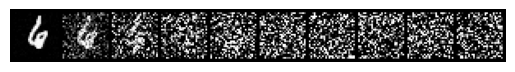

In [219]:
# Load a batch of images
image_batch, class_values = next(iter(dataloader))

# Example usage
sample_image = image_batch[0]  # Select the first image
sample_image = sample_image.unsqueeze(0).repeat(10, 1, 1, 1).to(gpu) # Repeat the image 10 times

timestep = torch.linspace(1, 999, 10, device=gpu).long() # 10 timesteps between 1 and 999

noised_image = forward_sample(sample_image, timestep, torch.randn_like(sample_image))
grid = torchvision.utils.make_grid(noised_image.cpu(), nrow=noised_image.size(0))
grid = grid.permute(1, 2, 0)  # Reorder dimensions to (H, W, C)
plt.axis('off')
plt.imshow(grid)

### Reverse diffusion example

Sampling loop time step.: 100%|██████████| 1000/1000 [00:05<00:00, 183.14it/s]


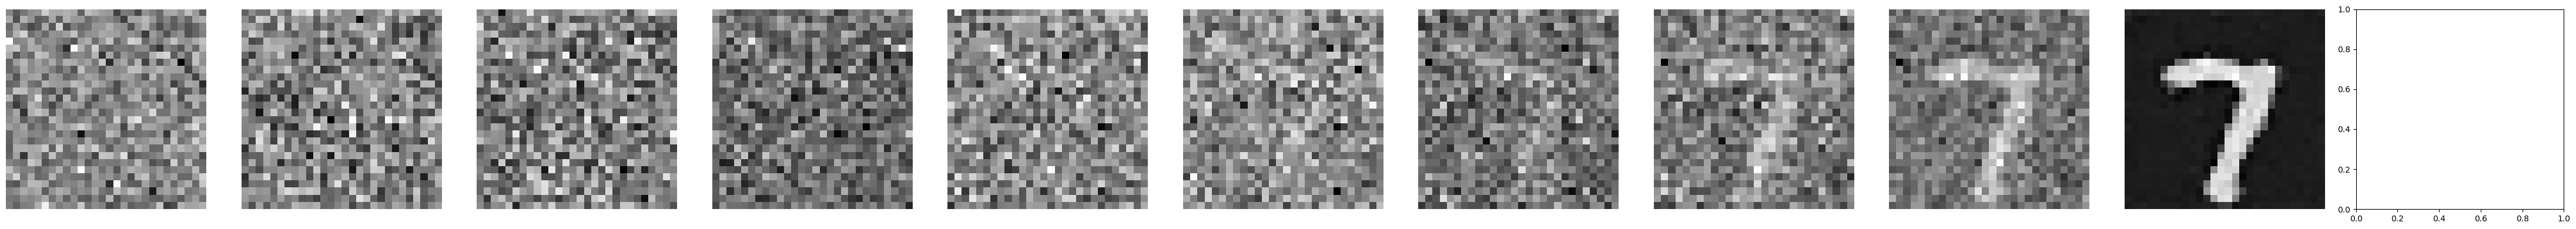

In [242]:

class_labels = torch.tensor([7], device=gpu)
class_labels = nn.functional.one_hot(class_labels, num_classes=10).float()
        
generated_samples = p_sample_loop(diffusion_model, shape=(10, channels, image_size, image_size), conditionals=class_labels, showPartial=100)

### Final results

Sampling loop time step.: 100%|██████████| 1000/1000 [00:12<00:00, 79.34it/s]


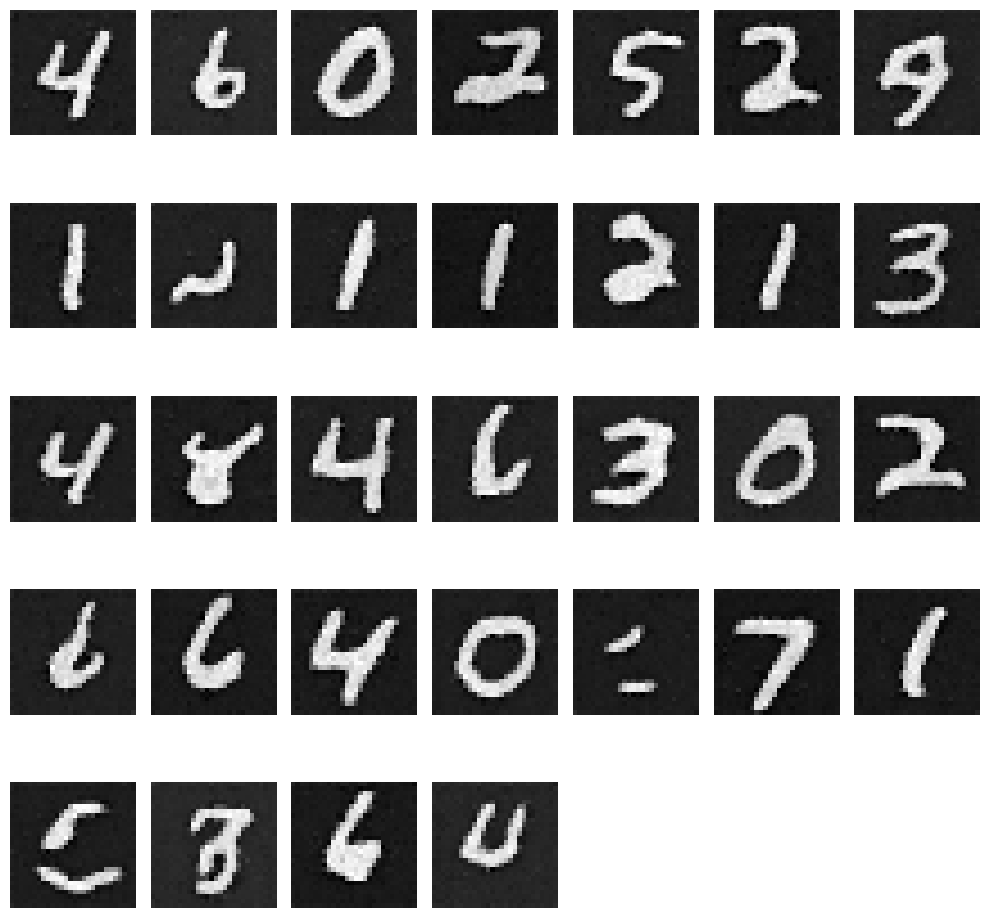

In [247]:
def plot_samples(images , rows=None):
    if torch.is_tensor(images):
        images = images.detach().cpu().numpy()

    if rows is None:
        rows = int(np.sqrt(len(images)))

    cols = len(images) // rows + (1 if len(images) % rows != 0 else 0)

    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

numbers = get_random_guidance()
numbers = nn.functional.one_hot(numbers, num_classes=num_classes)
numbers = numbers.type(torch.float32)

generated_images = p_sample_loop(diffusion_model, shape=(BATCH_SIZE, channels, image_size, image_size), conditionals=numbers)

plot_samples(generated_images)

# Model evaluation

### FID (Frechét inception distance)

In [ ]:
importlib.reload(generator)
if CALCULATE_FID:
    generator.add_mnist_original_images_if_not_exist()
    generate_images(total_images=10000, fid_batch_size=1000)
    fid_result = !python -m pytorch_fid ./dataset/test/ ./generated_images/
    fid_result = str(fid_result).split("FID:")[-1]
    fid_result = fid_result.replace(" ", "").replace("']", "")
    print(f"fid score: {fid_result}")

### Inception score

Generally, to get optimal scores, the model should create images that looks like the training distribution.
Since our model is guided, we can also try to force it to create an even amount of images of each class.

In [ ]:
desired_distribution = plot_utility.get_distribution(mnist, show_plot=True)

#### To evaluate, a model pretrained on MNIST images is used, making it a better classifier than inception-v3 for this specific dataset. 
(Note that inception scores are not directly comparable to papers that use inception-v3 even though the mathematical formulas are identical)

In [ ]:
importlib.reload(evaluator)
evaluator_model = evaluator.get_MNIST_evaluator(device=gpu)

In [ ]:
def get_all_same_guidance(number_class):
    """
    Creates a BATCH_SIZE long tensor where all entries are of class 'numberClass'
    """
    return torch.ones(200, dtype=torch.long, device=gpu) * int(number_class)



def show_example(num):
    """
    Shows an example of BATCH_SIZE images of the class corresponding to num
    """
    numbers = get_all_same_guidance(num)
    numbers = nn.functional.one_hot(numbers, num_classes=num_classes)
    numbers = numbers.type(torch.float32)
    
    
    generated_images = p_sample_loop(diffusion_model, shape=(200, channels, image_size, image_size), conditionals=numbers)
    
    actual_distribution = plot_utility.get_classification_distribution_batch_sum(evaluator=evaluator_model,
                                                                             input_batch=generated_images,
                                                                             device=gpu,
                                                                             channels=channels,
                                                                             show_plot=True,
                                                                             image_size=image_size)
    print(actual_distribution)
    
show_example(3)

In [ ]:
# Inception score

INCEPTION_ITERATIONS = 300
def calculate_inception_score():
    """
    Creates INCEPTION_ITERATIONS * BATCH_SIZE images and calculates the inception score of the images
    """
    distributions = []

    for i in tqdm(range(INCEPTION_ITERATIONS)):
        conditionals = get_all_same_guidance(i % num_classes)
        conditionals = nn.functional.one_hot(conditionals, num_classes=num_classes)
        conditionals = conditionals.type(torch.float32)
        
        image_batch = p_sample_loop(diffusion_model, shape=(BATCH_SIZE, channels, image_size, image_size), conditionals=conditionals, disable_tqdm=True)
        
        distribution = plot_utility.get_classification_distributions(evaluator=evaluator_model,
                                                                 input_batch=image_batch,
                                                                 device=gpu)
        distributions.extend(distribution)
        
    small_number = 1e-16 # This avoids undefined behaviour when taking the log of zero

    p_y_given_x = torch.cat(distributions, dim=0)

    p_y = p_y_given_x.mean(dim=0, keepdim=True)

    kl_divergence = p_y_given_x * (torch.log(p_y_given_x + small_number) - torch.log(p_y + small_number))
    sum_kl_divergence = kl_divergence.sum(dim=1)
    avg_kl_divergence = sum_kl_divergence.mean()

    is_score = torch.exp(avg_kl_divergence)
    return is_score

if CALCULATE_IS:
    inception_score = calculate_inception_score()
    print(f"Score is {inception_score}")